Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=True, num_epochs=1, n_train_stop=100, seed=1998, batch_size=64, num_workers=4, model_name='resnet50', do_scratch=False, lr=0.0001, delta1=0.05, delta2=0.001, weight_decay=0.0, shuffle=True, verbose=True)

# testing different networks

In [2]:
args = fovea.Params()
from retinoto_py import all_model_names

json_filename = args.data_cache / '13_model_comparison.json'

# %rm {json_filename}

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for do_mask in [True, False]:
        for dataset in fovea.all_datasets:
            for model_name in fovea.all_model_names:
                args = fovea.Params(model_name=model_name, do_mask=do_mask)
                VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
                val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
                model = fovea.load_model(args)
                param_stats = fovea.count_parameters(model)
                total_layers = fovea.count_layers(model)
                tic = fovea.time.time()
                accuracy = fovea.get_validation_accuracy(args, model, val_loader, f"Model {args.model_name}\t dataset: {dataset}\t(do_mask={do_mask})")            
                toc = fovea.time.time()
                this_result = { 'model_name': model_name,
                                'do_mask': do_mask,
                                'dataset': dataset,
                                'accuracy': accuracy,
                                'wall_clock_time': toc-tic,
                                'total_parameters': param_stats['total_parameters'],
                                'trainable_parameters': param_stats['trainable_parameters'],
                                'total_layers': total_layers}
                all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)


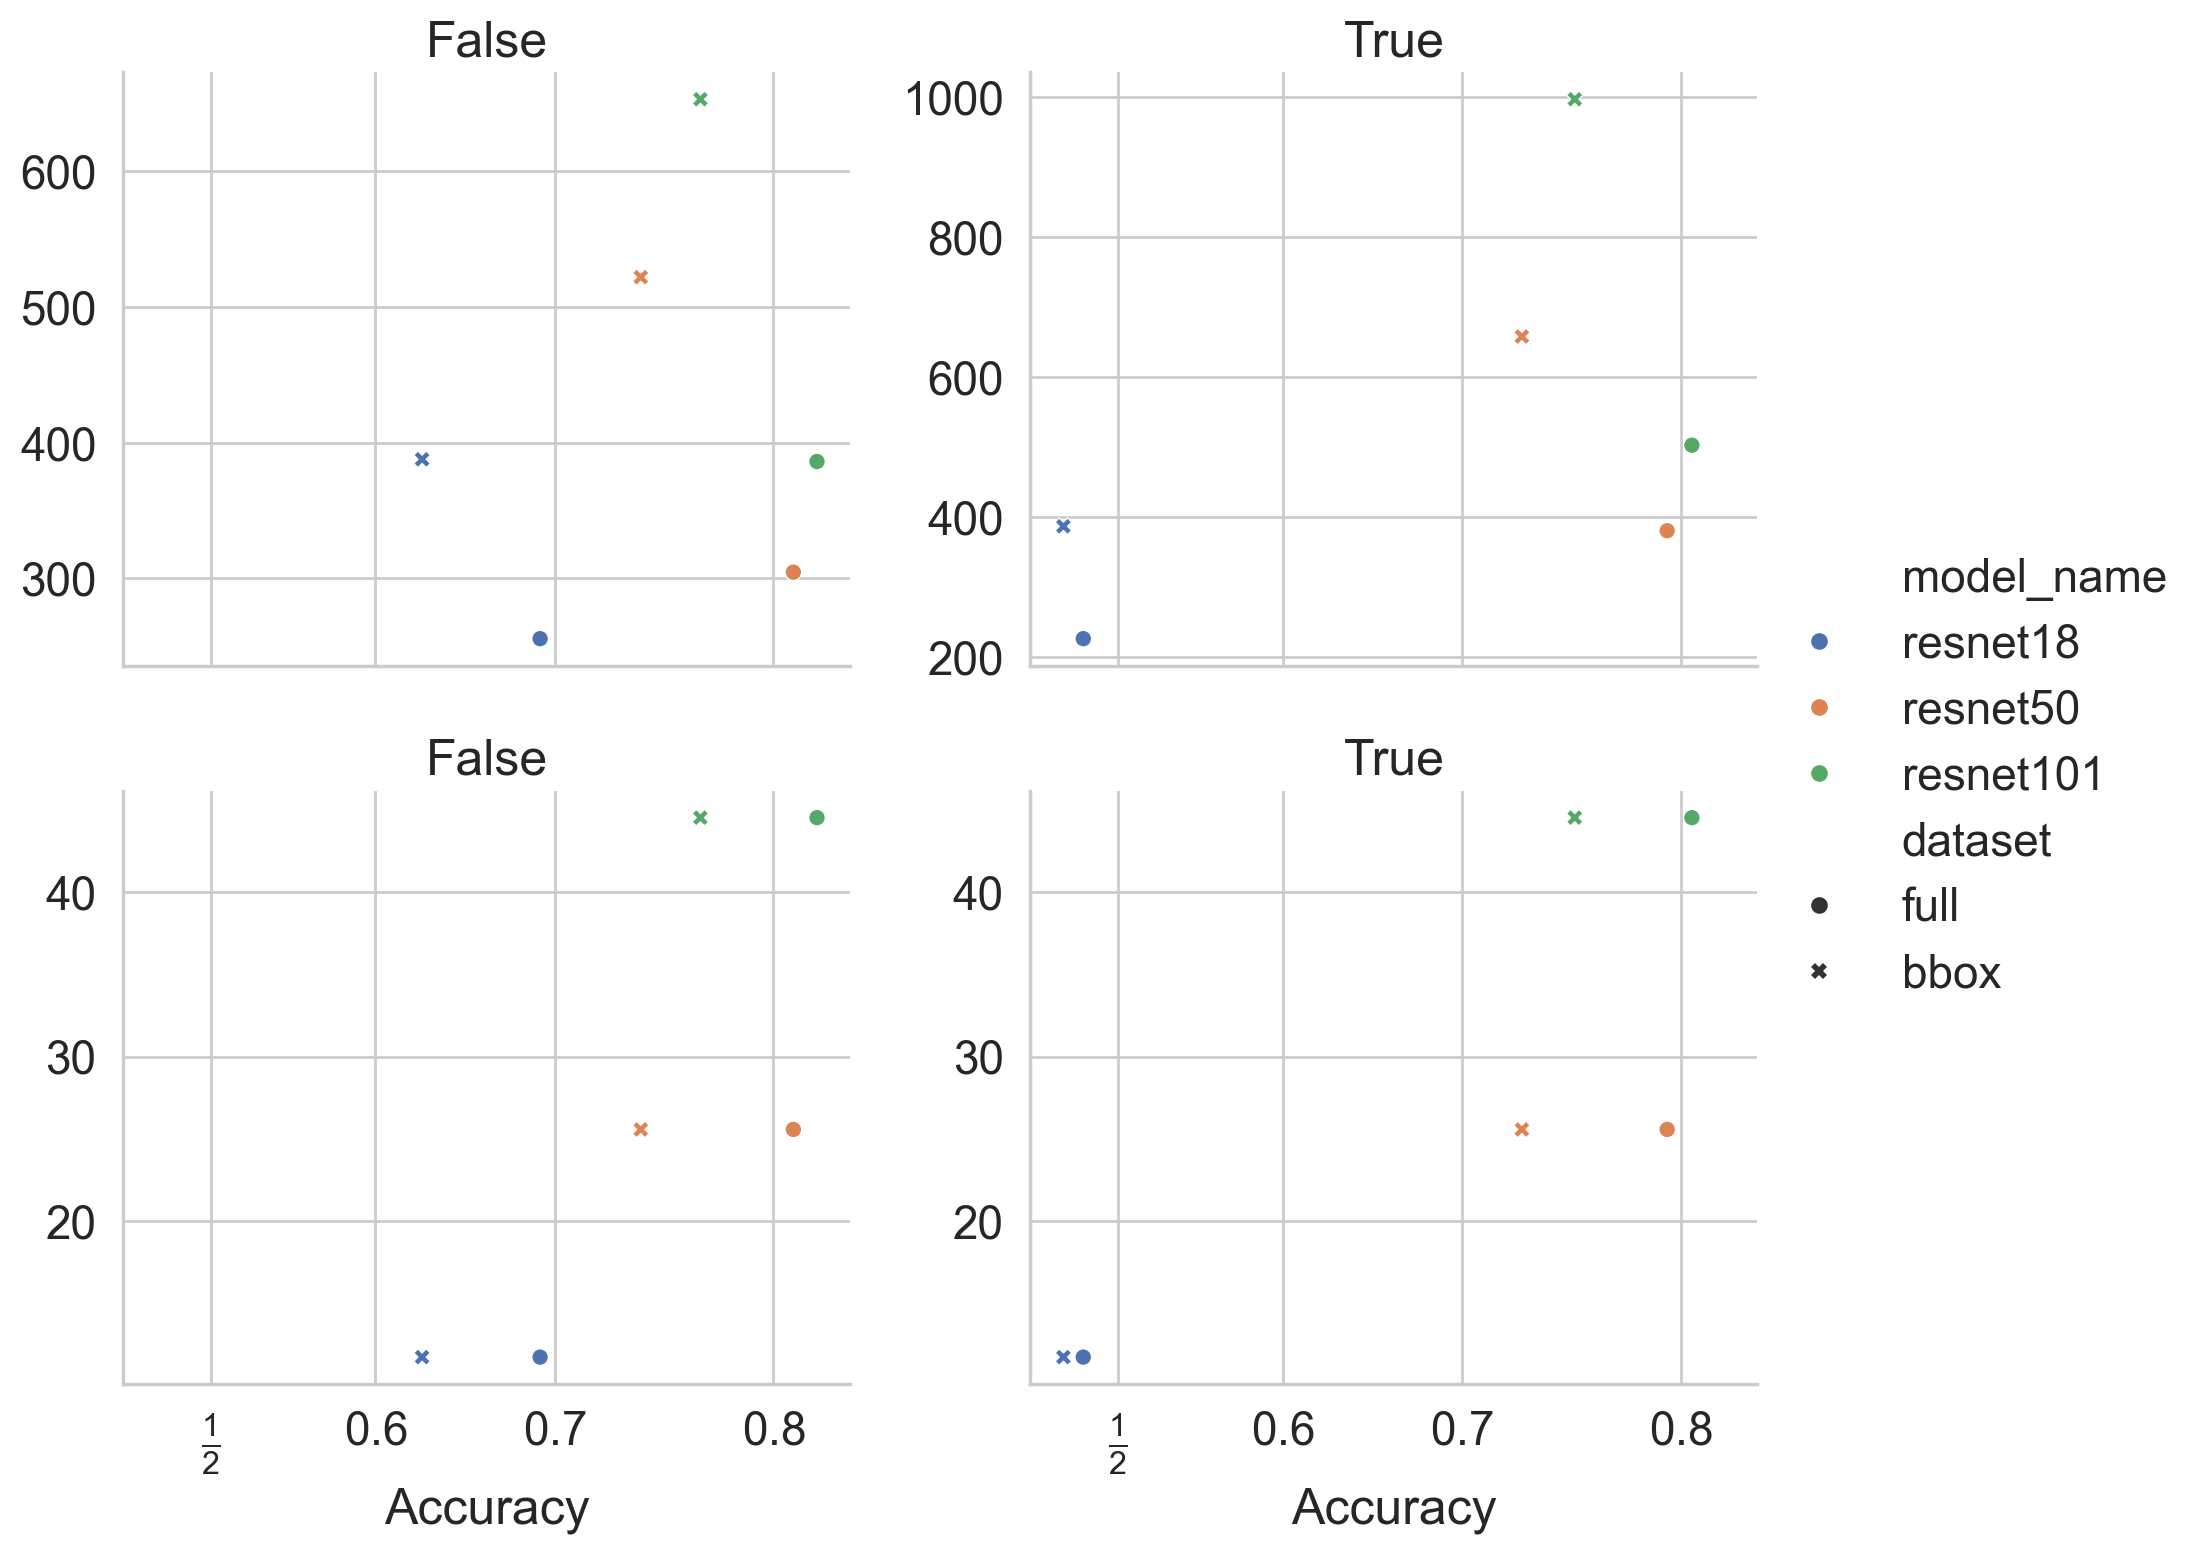

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Melt the DataFrame (Unchanged) ---
id_vars = ['do_mask', 'dataset', 'model_name', 'accuracy']
value_vars = ['wall_clock_time', 'total_parameters']
results_long = fovea.pd.melt(
    results,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='metric',
    value_name='value'
)

# Make the metric names more readable
metric_name_map = {
    'wall_clock_time': 'Wall Clock Time (s)',
    'total_parameters': 'Total Parameters (M)'
}
results_long['metric_label'] = results_long['metric'].map(metric_name_map)


# --- Step 2: Plot the POINTS using relplot ---
# Use kind='scatter' to get only points

g = fovea.sns.relplot(
    data=results_long,
    x='accuracy',
    y='value',
    
    hue='model_name',         # Color by model
    style='dataset',          # Style by dataset
    col='do_mask',            # One column for each masking condition
    row='metric_label',       # One row for each metric
    
    kind='scatter',           # KEY: PLOT ONLY POINTS
    markers=True,
    
    height=4,
    aspect=1.2,
    facet_kws={'sharey': False, 'sharex': True}
)

# --- Step 3: Manually ADD THE LINES (The Simple, Correct Way) ---

# Create a color map to ensure line colors match point colors
# palette = dict(zip(g.hue_names, fovea.sns.color_palette()))

# Get the array of axes from the figure
axes = g.axes

# Get all unique combinations for drawing lines
groups_to_draw = results_long[['do_mask', 'model_name']].drop_duplicates()

# Iterate over each combination
for _, row_data in groups_to_draw.iterrows():
    mask_val = row_data['do_mask']
    model_name = row_data['model_name']
    
    # Get the data for this specific model and mask condition
    subset = results_long[(results_long['model_name'] == model_name) & (results_long['do_mask'] == mask_val)]

    # We need exactly two points (one for each metric) to connect
    if len(subset) == 2:
        # Get the data for the two points
        p1 = subset[subset['metric'] == 'wall_clock_time'].iloc[0]
        p2 = subset[subset['metric'] == 'total_parameters'].iloc[0]
        
        # Determine which column of axes to draw on
        col_index = 1 if mask_val else 0
        
        # Get the axes for the top and bottom plots in that column
        ax_top = axes[0, col_index] # Wall Clock Time plot
        ax_bottom = axes[1, col_index] # Total Parameters plot
        
        # Get the line color from our palette
        color = palette[model_name]
        
        # --- Draw the connecting line ---
        # This is the simple, brilliant trick: we draw one vertical line on a hidden
        # axes object that spans the full height of the facet column.
        
        # Get the figure and the position of the subplot columns
        fig = g.fig
        # The transform allows us to use data coordinates for x_


# Improve axis labels
g.set_axis_labels("Accuracy", "")
g.set_titles("{col_name}") # Use metric names as subplot titles
g.set(xscale='logit')


In [ ]:
# [ax.set_xscale('logit') for ax in g.axes.flat]

# axes_list = [ax for ax in g.axes.flat]
# time_ax = axes_list[0]
# time_ax = g.axes.flat[0]
# time_ax.set_ylim(0, results_long[results_long['metric']=='wall_clock_time']['value'].max()*1.1)
# M_ax = g.axes.flat[1]
# M_ax.set_ylim(0, results_long[results_long['metric']=='total_parameters']['value'].max()*1.1)

# # Improve the legend to be more descriptive
# legend = g.legend
# new_labels = ['No Mask', 'With Mask'] # Assuming do_mask=False is plotted first
# for t, l in zip(legend.texts, new_labels):
#     t.set_text(l)
# g.legend.set_title('Masking Condition')

# # Add a main title for the whole figure
# g.fig.suptitle('Model Performance vs. Accuracy', y=1.02) # Adjust y to prevent overlap

# fovea.plt.tight_layout()
# fovea.plt.show()

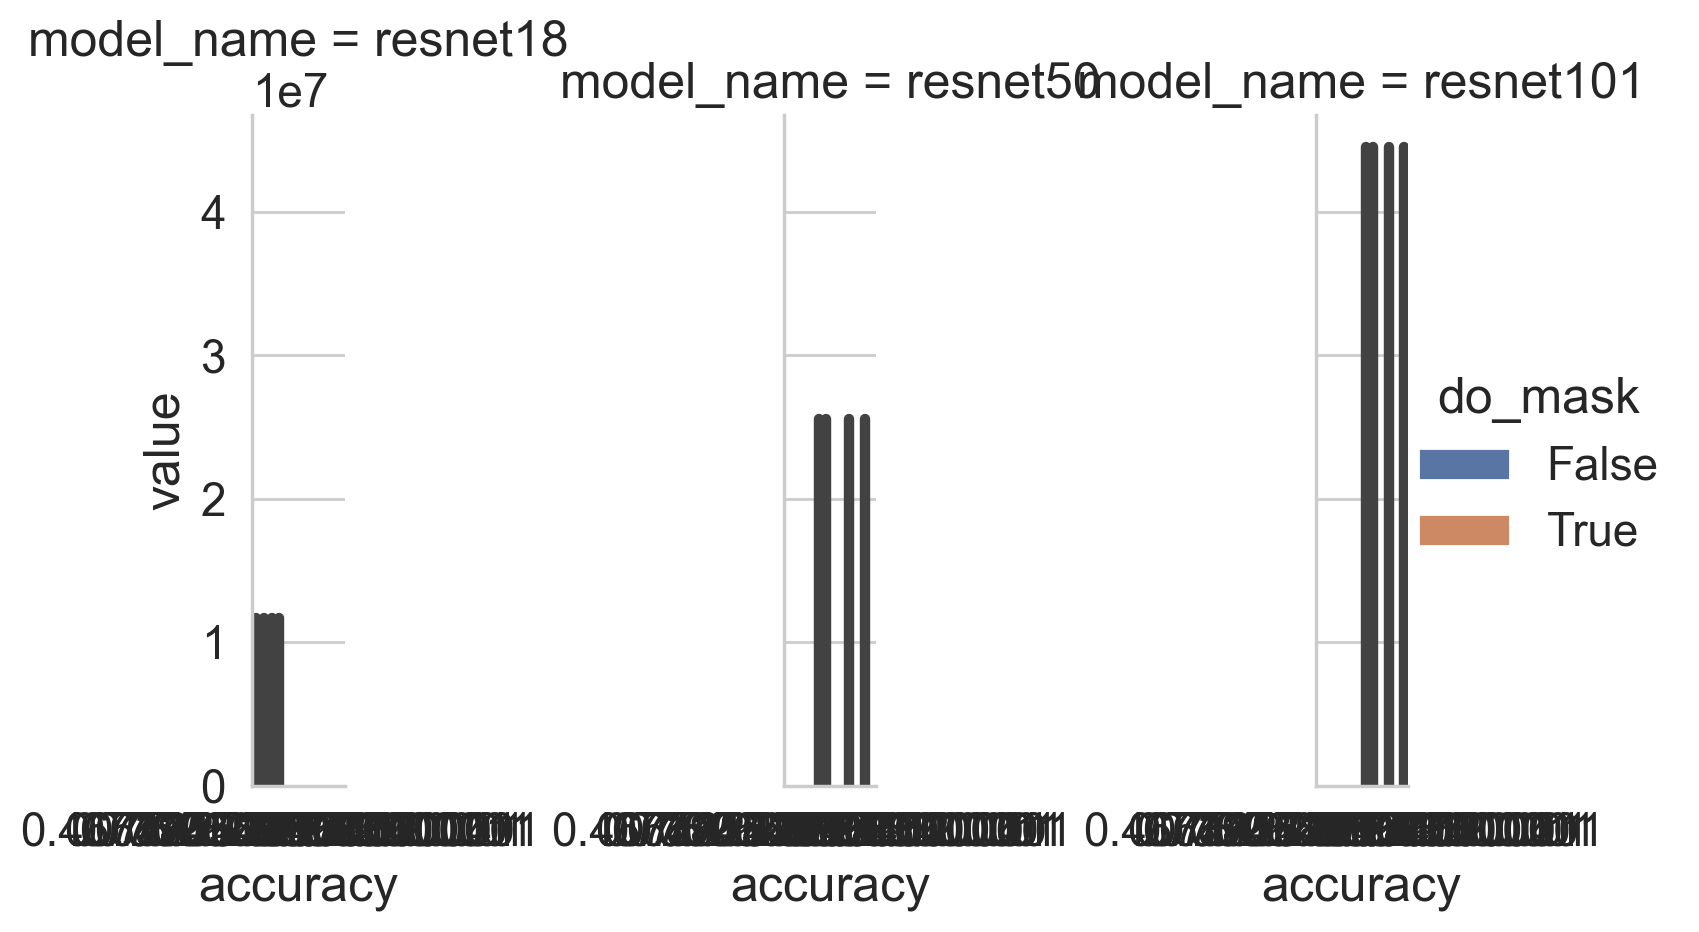

In [5]:
g = fovea.sns.catplot(
    results_long, kind="bar",
    x="accuracy", y="value", col="model_name", hue="do_mask",
    aspect=.5,
)